# **Face Recognition**


**Project Overview**

This project addresses the escalating demand for sophisticated and precise facial recognition systems across diverse domains, including security, attendance management, and user authentication. Leveraging advancements in deep learning techniques, the focus is on elevating the performance of these systems through the implementation of a custom Siamese neural network—a potent architecture renowned for its efficacy in face recognition tasks.

**Data Analysis**

The training dataset utilized for the custom Siamese neural network comprises images of classmates, ensuring diversity in facial expressions, lighting conditions, and angles. This diversity aims to fortify the model's resilience and adaptability in real-world scenarios.

**Data Preprocessing**

To prepare the dataset for training, a comprehensive data preprocessing pipeline was employed. This included resizing, normalization, and other essential transformations performed through a dedicated function to enhance the quality and suitability of the input images.

**Model Development**

The core of the project involved implementing a Siamese neural network, consisting of two identical convolutional neural networks running concurrently. This architecture effectively treats the system as a singular neural network with dual inputs. To optimize the learning process, a custom loss function was devised, leveraging the contrastive loss algorithm.

**Model Evaluation**

The performance evaluation of the model revealed exceptional results, showcasing an  accuracy of 86% on the test set and on the training set. Further insights into the model's training progress, including loss and accuracy metrics, are visually represented in the plotted graphs towards the end of the notebook.

This project not only contributes to the advancement of facial recognition systems but also underscores the efficacy of the custom Siamese neural network architecture in achieving robust and accurate results.

## Setup and Import Dependencies

In [90]:
import random
import numpy as np
import keras
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import os
import tensorflow as tf
import random
import pickle
import seaborn as sns
from sklearn.metrics import classification_report
from keras import regularizers
from keras import initializers

## Hyperparameters

In [53]:
epochs = 10
batch_size = 16
margin = 1  # Margin for contrastive loss.

## Initialize Data Folder

In [54]:
data_folder = '/content/drive/MyDrive/flatiron/cohort_faces/'

Steps:

- Load in the data
- Preprocess the images
- Visualize the images
- Create image pairs
- Load the model
- Predict on new dataset

## Helper Functions
- Preprocessing function
- visualization functions
- create image pairs function

In [124]:
def preprocess_image(image_path, target_size=(256,256), crop_faces=True):
    """Preprocesses the given image.

    Arguments:
        image_path: The path to the image file.
        target_size: A tuple of integers indicating the target size.
        crop_faces: A boolean indicating whether to crop faces from the image.

    Returns:
        A preprocessed image.
    """
    # Step 1: Load the image
    image = cv2.imread(image_path)

    # Step 2: Check if the image was loaded successfully
    if image is None:
        print("Failed to load image:", image_path)
        return None

    # Step 3: Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 4: Crop faces from the image if enabled
    if crop_faces:
        cascPath = '/content/drive/MyDrive/flatiron/haarcascade_frontalface_default.xml'
        faceCascade = cv2.CascadeClassifier(cascPath)
        faces = faceCascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(15,15))
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            gray_image = gray_image[y:y+h, x:x+w]

    # Step 5: Resize the grayscale image
    resized_image = cv2.resize(gray_image, target_size)

    # Step 6: Normalize pixel values
    normalized_image = resized_image / 255.0

    return normalized_image

In [125]:
def visualize_normalized_image(image):
    # Reshape the flattened image to its original shape
    target_shape = (256,256)  # Replace with the actual target size
    reshaped_image = np.reshape(image, target_shape)

    # Display the normalized image
    plt.imshow(reshaped_image, cmap='gray')
    plt.axis('off')
    plt.show()

In [126]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        # Ensure the pairs are properly formatted
        pair_to_show = np.concatenate([pairs[i][0], pairs[i][1]], axis=0)

        ax.imshow(pair_to_show, cmap="gray")

        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

## Create Image Pairs


In [127]:
def create_image_pairs(data_folder, max_pairs_per_person=45):
    person_folders = os.listdir(data_folder)
    image_pairs = []
    labels = []
    total_pairs_created = 0

    # Create an index of image files for each person
    person_images = {}
    for person_folder in person_folders:
        person_path = os.path.join(data_folder, person_folder)
        if not os.path.isdir(person_path):
            continue
        person_images[person_folder] = os.listdir(person_path)

    # Iterate through each person folder
    for person_folder in person_images:
        person_image_files = person_images[person_folder]
        pairs_created_for_person = 0

        # Create positive pairs within the same person folder
        for i in range(len(person_image_files)-1):
            for j in range(i+1, len(person_image_files)):
                if pairs_created_for_person >= max_pairs_per_person:
                    break

                image1_path = os.path.join(data_folder, person_folder, person_image_files[i])
                image2_path = os.path.join(data_folder, person_folder, person_image_files[j])
                preprocessed_image1 = preprocess_image(image1_path)
                preprocessed_image2 = preprocess_image(image2_path)
                if preprocessed_image1 is not None and preprocessed_image2 is not None:
                    image_pairs.append((preprocessed_image1, preprocessed_image2))
                    labels.append(0.0)  # Positive label
                    total_pairs_created += 1
                    pairs_created_for_person += 1

        # Create negative pairs with other person folders
        other_person_folders = [p for p in person_images if p != person_folder]
        for other_person_folder in other_person_folders:
            other_image_files = person_images[other_person_folder]

            for i in range(len(person_image_files)):
                for j in range(len(other_image_files)):
                    if pairs_created_for_person >= max_pairs_per_person:
                        break

                    image1_path = os.path.join(data_folder, person_folder, person_image_files[i])
                    image2_path = os.path.join(data_folder, other_person_folder, other_image_files[j])
                    preprocessed_image1 = preprocess_image(image1_path)
                    preprocessed_image2 = preprocess_image(image2_path)
                    if preprocessed_image1 is not None and preprocessed_image2 is not None:
                        image_pairs.append((preprocessed_image1, preprocessed_image2))
                        labels.append(1.0)  # Negative label
                        total_pairs_created += 1
                        pairs_created_for_person += 1

        print(f"Processed folder: {person_folder}, Pairs created: {pairs_created_for_person}/{max_pairs_per_person}")

    combined = list(zip(image_pairs, labels))
    random.shuffle(combined)
    image_pairs, labels = zip(*combined)

    return image_pairs, labels

In [128]:
# data = create_image_pairs(data_folder)

## Save data in a pickle file

so i can load it back in and wont have to run this function again.

In [129]:
# pickle.dump(data, open('/content/drive/MyDrive/flatiron/data.pkl', 'wb'))

In [130]:
data = pickle.load(open('/content/drive/MyDrive/flatiron/data.pkl', 'rb'))

In [131]:
image_pairs, labels = data

In [132]:
len(image_pairs)

495

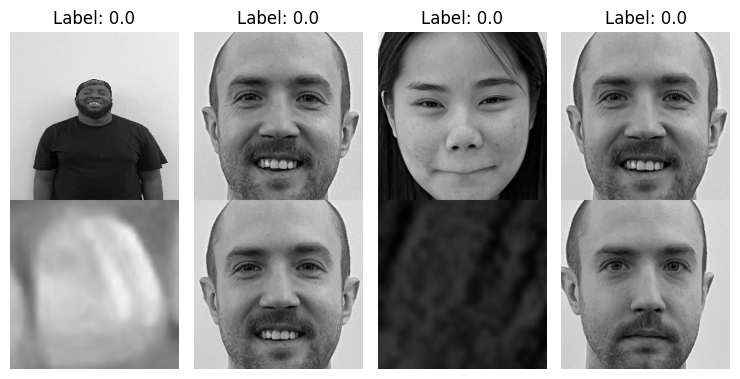

In [133]:
visualize(image_pairs[5:10], labels[5:10], to_show=4, num_col=4)

## Train Test Split

- split the data to have a holdout dataset to evaluate on

In [134]:
# Convert image_pairs and labels to NumPy arrays
image_pairs = np.array(image_pairs)
labels = np.array(labels)

# Split the data into training and testing sets
x_train_val, x_test, y_train_val, y_test = train_test_split(image_pairs, labels, test_size=0.2, random_state=42)

# Change the data type to a floating point format
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")

In [135]:
len(x_train_val)

396

In [136]:
# Keep 50% of train_val  in validation set
x_train, x_val = x_train_val[:198], x_train_val[198:]
y_train, y_val = y_train_val[:198], y_train_val[198:]
del x_train_val, y_train_val

In [137]:
x_train_1 = x_train[:, 0]  # x_train_1.shape is (18, 256, 256)
x_train_2 = x_train[:, 1]

x_val_1 = x_val[:, 0]  # x_val_1.shape = (18, 256, 256)
x_val_2 = x_val[:, 1]

x_test_1 = x_test[:, 0]  # x_test_1.shape = (9, 256, 256)
x_test_2 = x_test[:, 1]

In [138]:
x_test_1.shape

(99, 256, 256)

In [139]:
x_train_1.shape

(198, 256, 256)

In [140]:
x_val_1.shape

(198, 256, 256)

## Define Model

Now it's time for modeling.

In [141]:
@keras.saving.register_keras_serializable()
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.


    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

initializer = initializers.HeNormal()

input = keras.layers.Input((256, 256, 1))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(4, (5, 5), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(16, (5, 5), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="relu")(x)
embedding_network = keras.Model(input, x)


input_1 = keras.layers.Input((256, 256, 1))
input_2 = keras.layers.Input((256, 256, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
    [tower_1, tower_2]
)

siamese = keras.Model(inputs=[input_1, input_2], outputs=merge_layer)

## Define Contrastive Loss

Writing in a custom loss function to utilize in my model.

In [142]:
@keras.saving.register_keras_serializable()
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    @keras.saving.register_keras_serializable()
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - (y_pred), 0))
        return K.mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

## Compile the model with Contrastive Loss Function



In [143]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop")
siamese.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 input_22 (InputLayer)       [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 model_10 (Functional)       (None, 10)                   835238    ['input_21[0][0]',            
                                                                     'input_22[0][0]']            
                                                                                                  
 lambda_5 (Lambda)           (None, 1)                    0         ['model_10[0][0]',     

## Train Model

In [ ]:
history = siamese.fit(
    [x_train_1, x_train_2],
    y_train,
    validation_data=([x_val_1, x_val_2], y_val),
    batch_size=16,
    epochs=30,
)

## Show and Plot Results

Let's take a look at the results.

In [98]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")

    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()

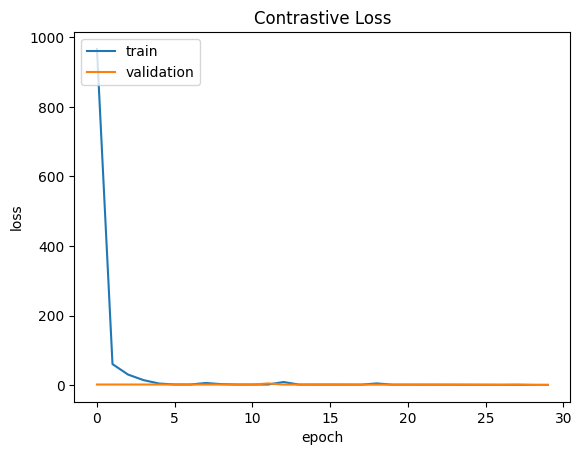

In [99]:
# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")
# plt.savefig('/content/drive/MyDrive/flatiron/p5_models/siamese_loss.png')

In [100]:
results = siamese.evaluate([x_test_1, x_test_2], y_test)
print("test loss:", results)

4/4 [==============================] - 2s 452ms/step - loss: 1.0012
test loss: 1.0011776685714722


Pretty good scores.

## Save Model

Going to save the model to use for deployment.

In [101]:
siamese.save('/content/drive/MyDrive/flatiron/p5_models/initializer.keras')
siamese.save('/content/drive/MyDrive/flatiron/p5_models/regularizer.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Reload Model

Reload the saved model to continue the process of predictions and verification.

In [113]:
siamese = keras.models.load_model('/content/drive/MyDrive/flatiron/p5_models/the_right_one.keras',
                                safe_mode=False,
                                custom_objects={'contrastive_loss': loss})

## Predictions

In [114]:
predictions = siamese.predict([x_test_1, x_test_2])
predictions

4/4 [==============================] - 2s 324ms/step


array([[0.01921166],
       [0.03031928],
       [0.04532048],
       [0.03850935],
       [0.03739066],
       [0.02269845],
       [0.01840314],
       [0.00395293],
       [0.02843262],
       [0.08273777],
       [0.05764734],
       [0.01406608],
       [0.03443813],
       [0.01860679],
       [0.08844582],
       [0.04022534],
       [0.08635297],
       [0.02599115],
       [0.07369379],
       [0.07365747],
       [0.07958855],
       [0.05509654],
       [0.01952471],
       [0.04537585],
       [0.06120206],
       [0.03418558],
       [0.03258362],
       [0.0665373 ],
       [0.03989462],
       [0.07233423],
       [0.01837518],
       [0.05094167],
       [0.07800294],
       [0.05884979],
       [0.02392452],
       [0.03156529],
       [0.05243257],
       [0.03684457],
       [0.07190568],
       [0.0290533 ],
       [0.07925074],
       [0.0655654 ],
       [0.09151165],
       [0.04938463],
       [0.02542529],
       [0.0044423 ],
       [0.0524634 ],
       [0.011

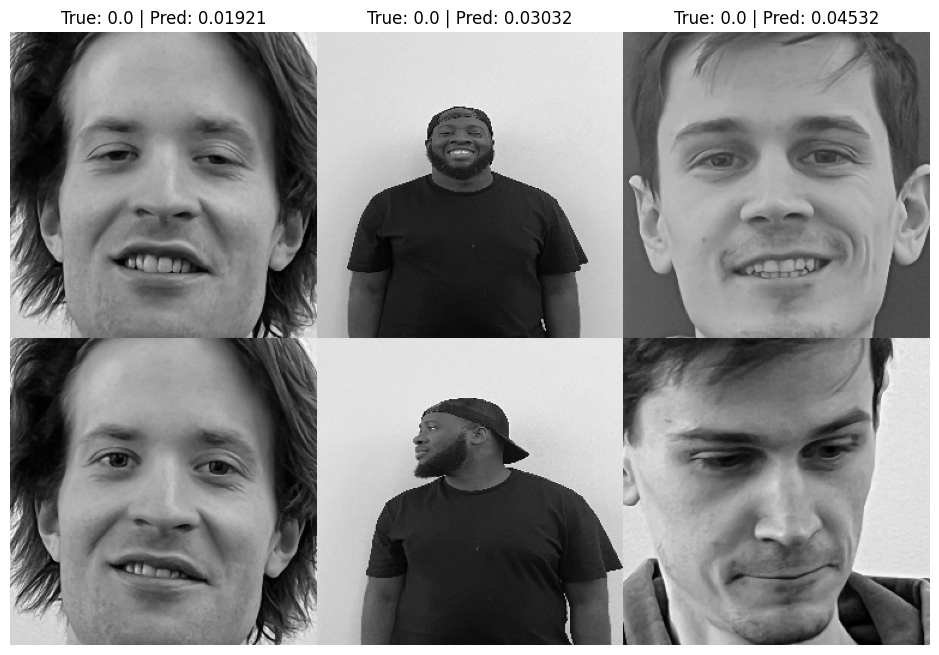

In [115]:
visualize(x_test, y_test, to_show=4, predictions=predictions, test=True)

## Define Accuracy Function

In [116]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)

In [117]:
compute_accuracy(y_test, predictions)

1.0

In [118]:
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]
print(classification_report(y_test, binary_predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        99

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



## Verification Function

Preprocessing:

The function performs preprocessing on both the input image and validation images. Make sure that the preprocessing steps are consistent with what was used during training the siamese model.

Comparing Shape:

The code checks if the shapes of input_img and validation_img are the same. While this is good for consistency, it might be helpful to log or handle cases where the shapes are different to understand why they might not match.

Result Storage:

The results list stores the model predictions. Ensure that the output shape of the siamese model matches the expected format.
Detection and Verification:

The code calculates the detection as the number of results above a detection_threshold, and then calculates the verification as the ratio of detection to the total number of results. This gives the percentage of images in the verification set that were detected as known faces. The verified variable is then determined based on a verification_threshold. Ensure these threshold values are chosen appropriately based on the characteristics of your model and dataset.

Result Analysis:

The code finds the index with the minimum score (min_score_index) and retrieves the corresponding name from the names list. This is a way to identify the "closest" match in the verification set.


In [121]:
# correct verification function
# input picture of me
def verify_image(model, detection_threshold, verification_threshold):
    results = []
    names = []

    verification_images_folder = '/content/drive/MyDrive/flatiron/application_data/verification_images'
    input_img = preprocess_image('/content/drive/MyDrive/flatiron/application_data/input_image/IMG_8879.jpeg')

    for folder in os.listdir(verification_images_folder):
        folder_path = os.path.join(verification_images_folder, folder)
        if not os.path.isdir(folder_path):  # Skip if it's not a directory
            continue
        for image_file in os.listdir(folder_path):
            if image_file.startswith('.'):  # Skip hidden files
                continue
            image_path = os.path.join(folder_path, image_file)
            validation_img = preprocess_image(image_path)

            # Check if input_img and validation_img have the same shape
            if input_img.shape != validation_img.shape:
                # Handle the mismatched shape
                continue

            print(f"Input Image Shape: {input_img.shape}")
            print(f"Validation Image Shape: {validation_img.shape}")

            result = model.predict([np.expand_dims(input_img, axis=0), np.expand_dims(validation_img, axis=0)])
            print(f"Prediction Result: {result}")
            results.append(result)
            names.append(os.path.splitext(folder)[0])

    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(results)
    verified = verification > verification_threshold

    # max_score_index = np.argmax(results)
    # name_with_max_score = names[max_score_index]

    min_score_index = np.argmin(results)
    name_with_min_score = names[min_score_index]

    return results, verified, name_with_min_score


results, verified, min_score_name = verify_image(siamese, 0.03, 0.03)
print(f"Verified: {verified}")
print(f"Welcome {min_score_name}")

Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 33ms/step
Prediction Result: [[0.01913585]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 31ms/step
Prediction Result: [[0.01869906]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 30ms/step
Prediction Result: [[0.01466936]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 49ms/step
Prediction Result: [[0.01171141]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 32ms/step
Prediction Result: [[0.03640387]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 29ms/step
Prediction Result: [[0.01014105]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [========================

In [ ]:
# could delete this after just trying it with less verification images
results, verified, max_score_name = verify_image(siamese, 0.3, 0.3)
print(f"Verified: {verified}")
print(f"Welcome {max_score_name}")

Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 49ms/step
Prediction Result: [[0.367487]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 75ms/step
Prediction Result: [[0.46138003]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 47ms/step
Prediction Result: [[0.44474643]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 73ms/step
Prediction Result: [[0.42675635]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 46ms/step
Prediction Result: [[0.40496168]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 45ms/step
Prediction Result: [[0.3406767]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [===========================

So the first try i wasnt verified but it found me as the right name, so i switched the thresholds and now it verifies correctly.

## Conclusion



